In [50]:
import json
import pandas as pd
import geopandas as gpd
import numpy as np
import database as db
import gdal
import rasterio
from sklearn.metrics import mean_squared_error
from math import sqrt
from rasterstats import zonal_stats
from munging import get_centroid
from apsim.daymet import create_excel_met
from apsim.apsim_input_writer import create_mukey_runs
from apsim.apsim_output_parser import parse_all_output_field, parse_summary_output_field
import matplotlib.pyplot as plt
#ogr2ogr -f "PostgreSQL" PG:"dbname=aepe port=5432 user=mjn password=KBlhsab7618 host=10.24.18.212" "accola_yield.geojson" -skip-failures

In [2]:
dbconn = db.connect_to_db('database.ini')

In [3]:
accola_soy_mgmt_2018 = json.loads( open( 'crop_jsons/accola_sfc_2018.json', 'r' ).read() )
accola_corn_mgmt_2019 = json.loads( open( 'crop_jsons/accola_cfs_2019.json', 'r' ).read() )

In [4]:
accola_soils = gpd.read_postgis('SELECT * FROM biocent_farms.accola_ssurgo;', dbconn, geom_col='wkb_geometry')
accola_mukeys = list(np.unique(accola_soils['mukey']))
#accola_soils = pd.read_sql('SELECT * FROM biocent_farms.accola_ssurgo;', dbconn)
#### Get centroid and create met file
#accola_centroid = get_centroid(accola_soils, 'areasymbol', 'wkb_geometry')
#create_excel_met(accola_centroid[0], accola_centroid[1], 2012, 2019, 'accola')

In [5]:
#create_mukey_runs(accola_mukeys, dbconn, 'sfc', 'accola.met', 'Accola', start_year=2017, end_year=2019, sfc_mgmt=accola_soy_mgmt_2018, cfs_mgmt=accola_corn_mgmt_2019)
create_mukey_runs(accola_mukeys, dbconn, 'cfs', 'accola.met', 'Accola', start_year=2017, end_year=2019, sfc_mgmt=accola_soy_mgmt_2018, cfs_mgmt=accola_corn_mgmt_2019)

Finished! All files created!


In [9]:
accola_maize_output_2019 = parse_summary_output_field("apsim_files/Accola/", year=2019)

In [28]:
accola_apsim_yield_2019 = accola_maize_output_2019[['mukey', 'corn_buac']]
accola_apsim_yield_2019

,mukey,corn_buac
0,2765537,165.43703
1,2800480,147.96298
2,2835021,169.84242
3,2835194,195.34778
4,2922031,164.70740
5,411333,151.28084


In [ ]:
#gdal Rasterize (vector to raster)
#raster analysis > zonal statistics
#user python rasterstats to calculate zonal statistics
# from rasterstats import zonal_stats
# stats = zonal_stats("tests/data/polygons.shp", "tests/data/elevation.tif")
# stats[1].keys()
# ['count', 'min', 'max', 'mean']
# [f['mean'] for f in stats]
# [756.6057470703125, 114.660084635416666]

In [ ]:
accola_yield = gpd.read_file("yield_monitor/Accola2019YieldwGeom.dbf")

In [ ]:
accola_yield_clean = accola_yield[['Yld_Vol_Dr','geometry']]
#accola_yield_clean['Yld_Vol_Dr'].describe()

In [13]:
stats = zonal_stats('C:/Users/mjn/Documents/Foresite/yield_monitor_data/accola_ssurgo.geojson', "C:/Users/mjn/Documents/Foresite/yield_monitor_data/accola_2019_yield_raster.tif", geojson_out=True)

In [31]:
accola_maize_2019 = gpd.GeoDataFrame.from_features(stats)
accola_maize_2019

,geometry,objectid,areasymbol,spatialver,musym,mukey,shape_length,shape_area,_count,_sum,_mean,_median,_stdev,_min,_max,min,max,mean,count
0,"MULTIPOLYGON (((-93.67114 41.97944, -93.67177 ...",1670419,IA169,9.0,L107,2835021,4532.587964,17372.778909,1027.0,1.876259e+05,182.693177,186.720093,26.237834,66.781502,245.805603,66.781502,245.805603,182.693190,1027
1,"MULTIPOLYGON (((-93.67638 41.98140, -93.67645 ...",1699584,IA169,9.0,L95,2835194,427.132962,9608.816987,617.0,1.001452e+05,162.309815,175.093201,55.368015,40.117100,273.226410,40.117100,273.226410,162.309816,617
2,"MULTIPOLYGON (((-93.66838 41.98085, -93.66838 ...",1673500,IA169,9.0,L138B,2765537,5151.993709,51175.383764,3105.0,6.888473e+05,221.850985,223.410599,31.126392,66.104897,348.802002,66.104897,348.802002,221.850986,3105
3,"MULTIPOLYGON (((-93.67787 41.97963, -93.67787 ...",1674524,IA169,9.0,6,411333,370.991947,422.984319,39.0,5.831197e+03,149.517880,157.001404,20.448641,102.758202,179.421295,102.758202,179.421295,149.517879,39
4,"MULTIPOLYGON (((-93.66838 41.97973, -93.66838 ...",1675300,IA169,9.0,L107,2835021,3939.586786,3689.868249,226.0,3.998885e+04,176.941802,187.816048,48.116209,42.994301,337.525299,42.994301,337.525299,176.941787,226
5,"MULTIPOLYGON (((-93.67577 41.98026, -93.67571 ...",1679582,IA169,9.0,L138B,2765537,550.387774,11041.134105,642.0,1.279321e+05,199.271186,201.629395,30.809508,82.115501,282.751801,82.115501,282.751801,199.271174,642
6,"MULTIPOLYGON (((-93.67305 41.98305, -93.67261 ...",1679975,IA169,9.0,L138B,2765537,1300.434886,5963.292117,365.0,7.641316e+04,209.351127,210.781097,32.295120,69.628998,336.448303,69.628998,336.448303,209.351113,365
7,"MULTIPOLYGON (((-93.67784 41.97951, -93.67786 ...",1689022,IA169,9.0,L507,2922031,42460.177496,131704.052460,7975.0,1.570600e+06,196.940452,203.940308,44.503792,40.268799,346.724609,40.268799,346.724609,196.940470,7975
8,"MULTIPOLYGON (((-93.66842 41.98255, -93.66840 ...",1689289,IA169,9.0,L55,2800480,922.446488,6182.684343,663.0,1.145793e+05,172.819454,182.495895,42.923843,40.689999,311.745087,40.689999,311.745087,172.819452,663
9,"MULTIPOLYGON (((-93.67227 41.97944, -93.67241 ...",1689439,IA169,9.0,L55,2800480,524.713926,6250.414950,365.0,5.170339e+04,141.653134,141.478699,43.498758,53.092400,226.033203,53.092400,226.033203,141.653136,365


In [39]:
accola_maize_2019 = accola_maize_2019[['objectid', 'mukey', 'mean']]
accola_maize_2019.sort_values('mukey')

,objectid,mukey,mean
2,1673500,2765537,221.850986
5,1679582,2765537,199.271174
6,1679975,2765537,209.351113
9,1689439,2800480,141.653136
16,1694874,2800480,211.362378
13,1689902,2800480,221.476579
12,1689892,2800480,201.635923
11,1689765,2800480,178.016364
10,1689585,2800480,214.434256
18,1694915,2800480,219.996199


In [55]:
pred_vs_obs = accola_maize_2019.merge(accola_apsim_yield_2019, on='mukey', how='left')
pred_vs_obs.columns = ['objectid', 'mukey', 'observed', 'predicted']
#pred_vs_obs.sort_values('mukey')

In [62]:
pred_vs_obs

,objectid,mukey,observed,predicted
0,1670419,2835021,182.693190,169.84242
1,1699584,2835194,162.309816,195.34778
2,1673500,2765537,221.850986,165.43703
3,1674524,411333,149.517879,151.28084
4,1675300,2835021,176.941787,169.84242
5,1679582,2765537,199.271174,165.43703
6,1679975,2765537,209.351113,165.43703
7,1689022,2922031,196.940470,164.70740
8,1689289,2800480,172.819452,147.96298
9,1689439,2800480,141.653136,147.96298


In [56]:
yield_monitor = tuple(pred_vs_obs['observed'])
apsim_predicted = tuple(pred_vs_obs['predicted'])

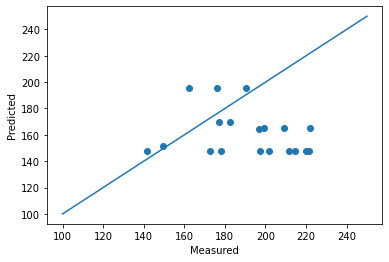

In [67]:
fig, ax = plt.subplots()
ax.scatter(yield_monitor, apsim_predicted)
ax.plot([100,250],[100,250])
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [57]:
rmse = mean_squared_error(yield_monitor, apsim_predicted, squared=False)
rmse

42.864657252573465

In [59]:
corr_matrix = np.corrcoef(yield_monitor, apsim_predicted)
corr_xy = corr_matrix[0,1]
r_squared = corr_xy**2
r_squared

0.04343078117267219

In [66]:
corr_xy

-0.2084005306439314

In [ ]:
#gdal.Grid('yield_avg.tif', 'accola_yield_basic.csv')

In [ ]:
len(accola_yield_clean.loc[accola_yield_clean['Yld_Vol_Dr'] <= 150])

In [ ]:
# For re-projecting input vector layer to raster projection
def reproject(vector_gpd, raster):
    proj = raster.crs.to_proj4()
    print("Original vector layer projection: ", vector_gpd.crs)
    reproj = vector_gpd.to_crs(proj)
    print("New vector layer projection (PROJ4): ", reproj.crs)
    fig, ax = plt.subplots(figsize=(15, 15))
    rplt.show(raster, ax=ax)
    reproj.plot(ax=ax, facecolor='none', edgecolor='red')
    fig.show()
    return reproj
#stats list: ['min', 'max', 'mean', 'count', 'sum', 'std', 'median', 'majority', 'minority', 'unique', 'range']
def get_zonal_stats(vector, raster, stats):
    # Run zonal statistics, store result in geopandas dataframe
    result = zonal_stats(vector, raster, stats=stats, geojson_out=True)
    geostats = gpd.GeoDataFrame.from_features(result)
    return geostats
    # For generating raster from zonal statistics result
def stats_to_raster(zdf, raster, stats, out_raster, no_data='y'):
    meta = raster.meta.copy()
    out_shape = raster.shape
    transform = raster.transform
    dtype = raster.dtypes[0]
    field_list = list_columns(stats)
    index = int(input("Rasterize by which field? "))
    zone = zdf[field_list[index]]
    shapes = ((geom,value) for geom, value in zip(zdf.geometry, zone))
    burned = rasterize(shapes=shapes, fill=0, out_shape=out_shape, transform=transform)
    show(burned)
    meta.update(dtype=rasterio.float32, nodata=0)
    # Optional to set nodata values to min of stat
    if no_data == 'y':
        cutoff = min(zone.values)
        print("Setting nodata cutoff to: ", cutoff)
        burned[burned < cutoff] = 0 
    with rasterio.open(out_raster, 'w', **meta) as out:
        out.write_band(1, burned)
    print("Zonal Statistics Raster generated")